EKF implementation for differential drive vehicle.

Authors: Håvard Brenne and Marcus Lerfald

In [84]:
from math import sin, cos, remainder
import numpy as np
    
class Vehicle:
    def __init__(self, measurement_stds, T=0.01):
        # x: x, y, theta, v
        # u: a, omega
        self.T = T
        self.measurement_stds = measurement_stds

    def f(self, x, u, enable_noise=True):
        # Zero-order hold discretization. x_dot ≈ 1/dt(x_k+1 - x_k)
        # Ad = I + A*dt, Bd = B*dt
        # x_dot = v*cos(theta)
        # y_dot = v*sin(theta)
        # theta_dot = omega
        # v_dot = a
        B = np.array([
            [0, 0],
            [0, 0],
            [0, 1],
            [1, 0]
        ])
        A = np.zeros((x.size, x.size))
        A[0,3] = cos(x[2])
        A[1,3] = sin(x[2])
        
        Ad = np.eye(x.size) + A*self.T
        Bd = B*self.T
        x_new = Ad @ x + Bd @ (u + enable_noise*np.random.normal(0, self.measurement_stds[-2:]))
        x_new[2] = remainder(x_new[2], 2*np.pi)  # Limit to -pi~pi
        return x_new

    def F(self, x):
        return np.array([
            [1, 0, -x[3]*self.T*sin(x[2]), self.T*cos(x[2])],
            [0, 1, x[3]*self.T*cos(x[2]), self.T*sin(x[2])],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])

    def g(self, x, enable_noise=True):
        Cd = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])
        return Cd @ x + enable_noise*np.random.normal(0, self.measurement_stds[:2]).T

    def G(self):
        return np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])

Four different nosie levels for position, angular rate and linear acceleration measurements are compared. Initialize one of the corresponding measurements noise standard deviations below. 

In addition, a longer simulation time is performed for the last cell.

Resulting plots of the experiments are saved below easier comparison.

In [66]:
# Low noise in position, angular rate and linear acceleration
# Short simulation

measurement_stds = np.array([0.3,0.3,0.05,0.1])
num_iterations = 10000

In [67]:
# High position noise, low angular rate and linear acceleration noise
# Short simulation

measurement_stds = np.array(([3.0,3.0,0.05,0.1]))
num_iterations = 10000

In [68]:
# Low position noise, high angular rate and linear acceleration noise
# Short simulation

measurement_stds = np.array(([0.3,0.3,0.1,0.2]))
num_iterations = 10000

In [69]:
# High position, angular rate and linear acceleration noise
# Long simulation

measurement_stds = np.array(([3.0,3.0,0.1,0.2]))
num_iterations = 50000

In [70]:
# Low noise in position, angular rate and linear acceleration
# Long simulation

measurement_stds = np.array([0.3,0.3,0.05,0.1])
num_iterations = 50000

In [81]:
measurement_stds = np.array([0.3,0.3,5000,10000])
num_iterations = 50000

In [82]:
from math import remainder
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)   # For repeatability

num_states = 4
num_measurements = 2

position_update_freq = 100
timesteps = np.arange(0,num_iterations)

trajectory = np.empty((0,num_states), float)
ground_truth = np.empty((0,num_states), float)
NIS = np.empty((0,1), float)
NEES = np.empty((0,1), float)

# Initialize model
x0 = np.array([0]*num_states)
P0 = 1e-4*np.eye(num_states)
gt = x0

vehicle = Vehicle(measurement_stds=measurement_stds)

u = np.vstack((num_iterations*[0.1], num_iterations*[0.5]))
u[0, num_iterations//4:3*num_iterations//4] = 0 # Drive in a circle for 3/5 the simulation

x_prev = x0
P_prev = P0

Q = np.diag([1e-1,1e-1,1e-2,5e-2])**2
R = np.diag(measurement_stds[:2])**2

G = vehicle.G()

k = 0
while k <= num_iterations - 1:
    
    # Prediction step
    P_pred = vehicle.F(x_prev) @ P_prev @ vehicle.F(x_prev).T + Q
    x_pred = vehicle.f(x_prev, u[:,k], enable_noise=False)
    
    # Kalman gain and covariance
    S = G @ P_pred @ G.T + R    # Innovation covariance
    K = np.linalg.solve(S.T, (P_pred @ G.T).T).T   # Faster than P_pred @ G.T @ np.linalg.inv(G @ P_pred @ G.T + R)
    P = (np.eye(num_states) - K @ G) @ P_pred
    P_prev = P
    
    gt = vehicle.f(gt, u[:,k], enable_noise=False)
    if (k % position_update_freq == 0):
        # Update step
        y = vehicle.g(vehicle.f(gt, u[:,k], enable_noise=True), enable_noise=True)
        g = vehicle.g(x_pred, enable_noise=False)
        innovation = y - g
        x = x_pred + K @ innovation
        x_prev = x

        NIS = np.vstack((NIS, innovation.T @ np.linalg.solve(S, innovation)))
    else:
        x = x_pred
        x_prev = x

    # Store estimated trajectory
    trajectory = np.vstack((trajectory, x))

    # Store ground truth
    ground_truth = np.vstack((ground_truth, gt))
    estimation_error = gt - x
    estimation_error[2] = remainder(estimation_error[2], 2*np.pi) # Limit to -pi~pi

    NEES = np.vstack((NEES, estimation_error.T @ np.linalg.solve(P, estimation_error)))

    # Cunt iterations
    k+=1
    
ANIS = np.mean(NIS)
ANEES = np.mean(NEES)

ANIS: 2.49
ANEES: 5.06
NIS within 95.00 percentile: 92.00%
NEES within 95.00 percentile: 80.50%
RMSE in position estimate: 0.254
Maximum error in position estimate: 1.04


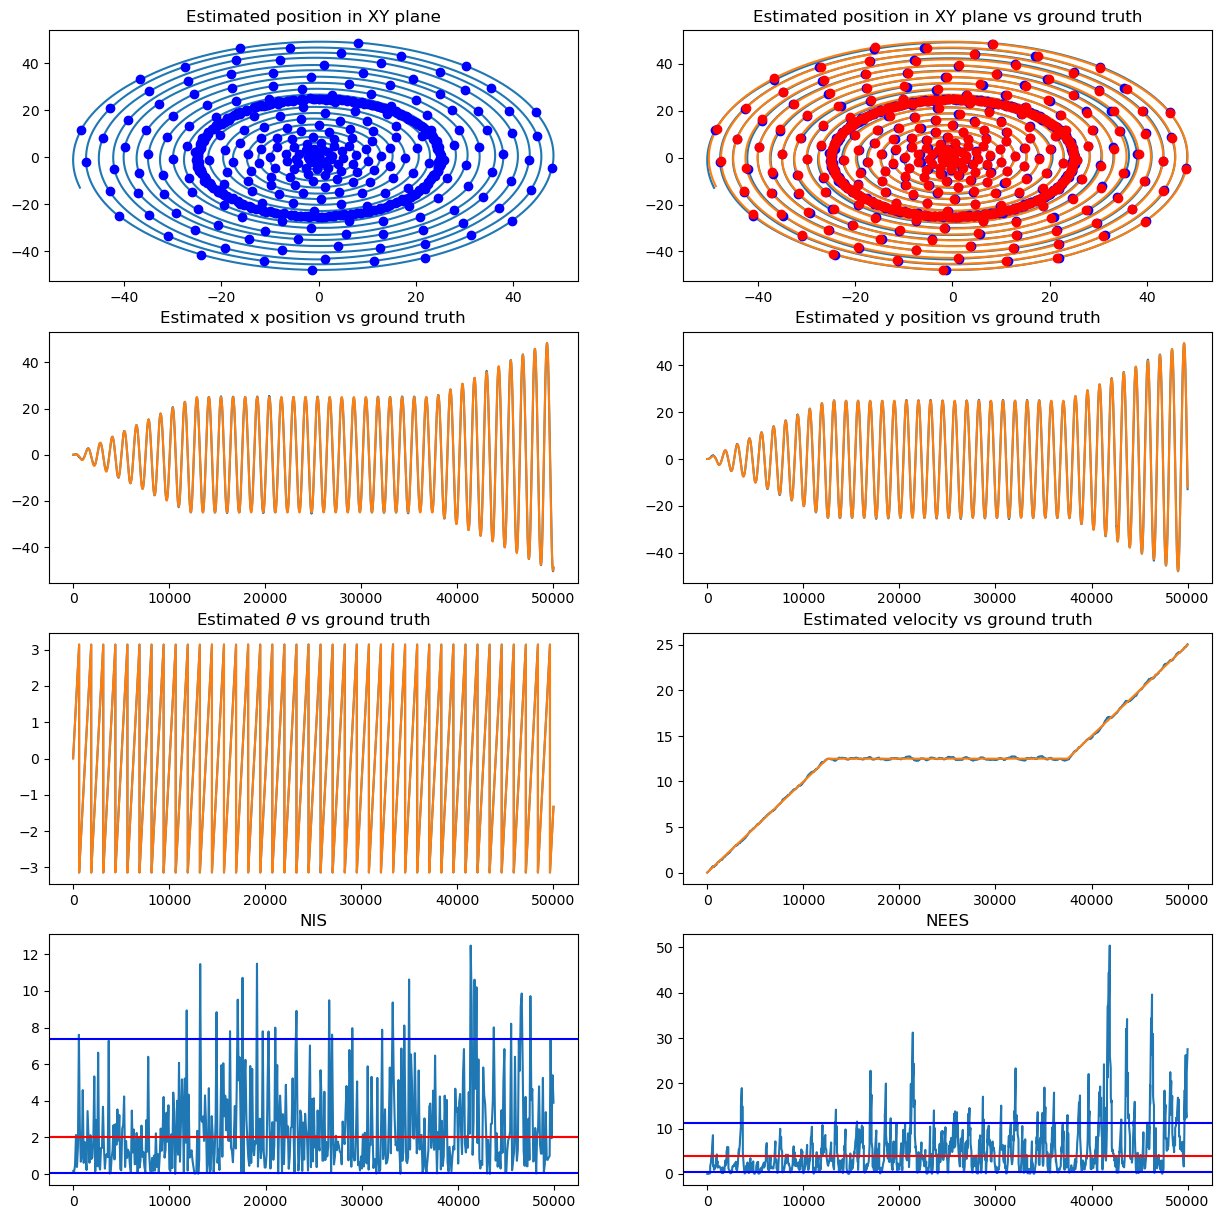

In [73]:
from scipy.stats.distributions import chi2

# Using https://arxiv.org/abs/1807.08855 for tuning
print(f"ANIS: {ANIS:.2f}")
print(f"ANEES: {ANEES:.2f}")

confidence = 0.95
alpha = 1 - confidence
NEES_bounds = [chi2.ppf(alpha/2, df=num_states), chi2.ppf(1-alpha/2, df=num_states)]
NIS_bounds = [chi2.ppf(alpha/2, df=num_measurements), chi2.ppf(1-alpha/2, df=num_measurements)]

NIS_within_bounds = ((NIS_bounds[0] < NIS) & (NIS < NIS_bounds[1])).sum()/NIS.size
NEES_within_bounds = ((NEES_bounds[0] < NEES) & (NEES < NEES_bounds[1])).sum()/NEES.size

print(f"NIS within {confidence*100:.2f} percentile: {NIS_within_bounds*100:.2f}%")
print(f"NEES within {confidence*100:.2f} percentile: {NEES_within_bounds*100:.2f}%")

print(f"RMSE in position estimate: {np.sqrt(np.mean((trajectory[:,:2]-ground_truth[:,:2])**2)):.3f}")

print(f"Maximum error in position estimate: {np.max(np.sqrt((trajectory[:,:2]-ground_truth[:,:2])**2)):.2f}")

# Plotting
plt.rcParams['figure.figsize'] = [15, 15]
fig, axs = plt.subplots(4, 2)
axs[0,0].plot(trajectory[:,0], trajectory[:,1])
axs[0,0].plot(trajectory[::position_update_freq,0], trajectory[::position_update_freq,1], 'bo')
axs[0,0].set_title('Estimated position in XY plane')
axs[0,1].plot(trajectory[:,0], trajectory[:,1], ground_truth[:,0], ground_truth[:,1])
axs[0,1].plot(trajectory[::position_update_freq,0], trajectory[::position_update_freq,1], 'bo')
axs[0,1].plot(ground_truth[::position_update_freq,0], ground_truth[::position_update_freq,1], 'ro')
axs[0,1].set_title('Estimated position in XY plane vs ground truth')
states = ["x position","y position",r"$\theta$","velocity"]
for i in range(num_states):
    axs[1+i//2, i%2].plot(timesteps, trajectory[:,i], ground_truth[:,i])
    axs[1+i//2, i%2].set_title(f'Estimated {states[i]} vs ground truth')
axs[3,0].plot(timesteps[::position_update_freq], NIS[:,0])
axs[3,0].axhline(y = num_measurements, color = 'r', linestyle = '-')
axs[3,0].set_title('NIS')
axs[3,0].axhline(y = num_measurements, color = 'r', linestyle = '-')
[axs[3,0].axhline(y = i, color = 'b', linestyle = '-') for i in NIS_bounds]
axs[3,1].plot(timesteps, NEES[:,0])
axs[3,1].set_title('NEES')
axs[3,1].axhline(y = num_states, color = 'r', linestyle = '-')
[axs[3,1].axhline(y = i, color = 'b', linestyle = '-') for i in NEES_bounds]
pass

With higher noise in position measurements, the EKF estimates of position will deviate further. The long simulation with low noise has a position estimate $RMSE = 0.264$, with a maximum deviation of 1.07m. When increasing the noise, we get an $RMSE=1.451$ with a maximum deviation in position of 4.85m. Since we calculated our R matrix from the noise standard deviations, we were still able to achieve filter consistency as described below.
Higher noise in angular rate and linear acceleration measurement will result in a reduced ability to track the orientation and velocity of our vehicle between position updates. However, when the position 

The process and measurement covariance matrices Q and R have been tuned with the low noise experiment. Usually, the R matrix can be determined directly from the measured noise covariance, while Q often needs tuning.

We are using the same Q for the EKF when altering the noise, assuming the change is unknown to us. In the configuration we have used, the angular rate and linear acceleration measurement noise appears in Q because they are modeled as inputs to the system, while the position measurement noise appears in R. The R matrix is calculated from the standard deviation of the known noise in our position estimate. This is often the case in practice. In this experiment, the input noise is unknown and the Q matrix is a result of tuning by hand. Looking at the plots for normalized innovation squared (NIS) and normaized estimation error squared (NEES), the filter become overconfident in the higher noise experiments. This is due to the low covariances in the tuned Q matrix relative to the actual process noise.

The tuning was done iteratively by looking at values for NIS and NEES and their confidence bounds. The NIS is chi-square distributed with an expected value equal to the number of measurements. The NEES follows a similar distribution, with expected value equal to the number of states. By calculating bounds for a confidence interval for these distributions and comparing them to the NIS/NEES, we determine the filter consistency. If the NIS/NEES falls within the bounds at a given timestep *k*, we can be 95% certain that the filter is consistent at *k*. If the NIS/NEES is *below* the lower bound, the filter is *underconfident*. If it is *above*, it is *overconfident*. We can use this fact to determine whether the elements of Q (and R) matrix should be decreased or increased. In practice, one is often limited to analyzing the NIS only because the NEES calculation depends on an available ground truth. In this experiment, we could imagine an approximate ground truth being available through RTK GNSS or motion capture systems.
